In [40]:
import torch
from mlcolvar.data import DictModule
from mlcolvar.utils.io import load_dataframe, create_dataset_from_trajectories
from mlcolvar.cvs.committor.utils import compute_committor_weights

# number of atoms
n_atoms=10

# temperature in Kelvin
T = 300 

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

load_args = [{'start' : 0, 'stop' : 1000, 'stride' : 1},
               {'start' : 0, 'stop' : 1000, 'stride' : 1}]
dataset = create_dataset_from_trajectories(
    trajectories=[
        "/home/etrizio/alad/boundary/A/alad.trr",
        "/home/etrizio/alad/boundary/B/alad.trr"
    ],
    top=[
        "/home/etrizio/alad/boundary/A/alad.gro",
        "/home/etrizio/alad/boundary/B/alad.gro"
         ],
    cutoff=10.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False,
    load_args=[{'start' : 0, 'stop' : 100, 'stride' : 1},
               {'start' : 0, 'stop' : 100, 'stride' : 1}]
)

bias = torch.zeros(len(dataset))

dataset = compute_committor_weights(dataset=dataset, bias=bias, data_groups=[0,1], beta=beta)

datamodule_graph = DictModule(dataset, lengths=[1], shuffle=False)
print(datamodule_graph)

Beta: 0.4009078751268027 
1/beta: 2.4943386299999997
DictModule(dataset -> DictDataset( "data_list": 200, "z_table": [6, 7, 8], "cutoff": 10.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=200, shuffle=False))


In [41]:
from mlcolvar.cvs.committor import Committor
from mlcolvar.core.nn.graph.schnet import SchNetModel
import torch

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=16,
                        n_layers=3,
                        n_filters=20,
                        n_hidden_channels=18,
                        w_out_after_sum=True,
                        aggr='mean'
                    )

# model = Committor(model=gnn_model,
#                   mass=torch.Tensor([12, 19]),
#                   alpha=1)

options = {'optimizer' : {'lr' : 5e-4},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.99995
        }}

model = Committor(model=gnn_model,
                  mass=torch.Tensor([12, 14, 16]),
                  alpha=1,
                  options=options)


In [42]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cpu',
    max_epochs=5000,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

trainer.fit(model, datamodule_graph)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


In [43]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model(test)

In [44]:
out_graph

tensor([[9.9999e-01],
        [9.9908e-01],
        [1.4645e-10],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [3.3151e-05],
        [8.2825e-11],
        [1.7765e-05],
        [1.0000e+00],
        [1.2522e-10],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [6.2965e-05],
        [1.0000e+00],
        [7.4145e-12],
        [1.7291e-12],
        [9.9991e-01],
        [1.1966e-06],
        [1.5066e-11],
        [1.0000e+00],
        [2.7240e-11],
        [1.0000e+00],
        [5.3953e-11],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [8.8269e-06],
        [1.1615e-11],
        [9.9997e-01],
        [9.9966e-01],
        [9.3869e-10],
        [9.9998e-01],
        [1.0000e+00],
        [9.9918e-12],
        [3.0339e-12],
        [1.0000e+00],
        [2.1248e-08],
        [4.5482e-05],
        [9.9995e-01],
        [1.3278e-06],
        [8.9072e-09],
        [9

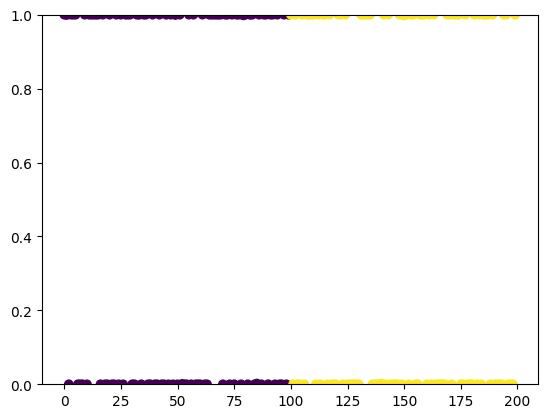

In [45]:
import matplotlib.pyplot as plt

# plt.hist(out_graph.detach().squeeze())
plt.scatter(torch.arange(len(dataset)).numpy(), out_graph.detach().squeeze(), c=[dataset['data_list'][i]['graph_labels'] for i in range(len(dataset))])
plt.ylim(0,1)
plt.show()